In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import time

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
# Loading Data
loan_data_inputs_train = pd.read_csv(r'C:\Users\WIN8\Desktop\PGDS 2020\Models\Lending Club Credit Risk\Processed Datasets for PD New\loan_data_inputs_train.csv', index_col = 0)
loan_data_targets_train = pd.read_csv(r'C:\Users\WIN8\Desktop\PGDS 2020\Models\Lending Club Credit Risk\Processed Datasets for PD New\loan_data_targets_train.csv', index_col = 0, header = 0)
loan_data_inputs_validation = pd.read_csv(r'C:\Users\WIN8\Desktop\PGDS 2020\Models\Lending Club Credit Risk\Processed Datasets for PD New\loan_data_inputs_validation.csv', index_col = 0)
loan_data_targets_validation = pd.read_csv(r'C:\Users\WIN8\Desktop\PGDS 2020\Models\Lending Club Credit Risk\Processed Datasets for PD New\loan_data_targets_validation.csv', index_col = 0, header = 0)
loan_data_inputs_test = pd.read_csv(r'C:\Users\WIN8\Desktop\PGDS 2020\Models\Lending Club Credit Risk\Processed Datasets for PD New\loan_data_inputs_test.csv', index_col = 0)
loan_data_targets_test = pd.read_csv(r'C:\Users\WIN8\Desktop\PGDS 2020\Models\Lending Club Credit Risk\Processed Datasets for PD New\loan_data_targets_test.csv', index_col = 0, header = 0)

In [3]:
#loan_data_inputs_train
#loan_data_targets_train
#loan_data_inputs_validation
#loan_data_targets_validation
#loan_data_inputs_test
#loan_data_targets_test

## Scoring

In [4]:
# dataframe where we track all cross-validation scoring metrics
df_cv_scores = pd.DataFrame({'model':['dummy'], 'accuracy':[0], 'f1':[0], 'roc_auc':[0]}, 
                            columns=['accuracy','f1','roc_auc'], index=['model'])
df_cv_scores_pca = df_cv_scores.copy()

df_y_pred_probas = pd.DataFrame({'model':np.zeros(loan_data_inputs_validation.shape[0])}) 
df_y_preds = pd.DataFrame({'model':np.zeros(loan_data_inputs_validation.shape[0])})  

# function adjusts class predictions based on the prediction threshold
def adjust_proba(probs, threshold):
    return [1 if proba >= threshold else 0 for proba in probs]

# function for computing 5-fold cross-validation scoring scores
def predict_evaluate_cv(model, X, y, df_cv_scores):
    cv = StratifiedKFold(n_splits=5, random_state=9999) 
    score_accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    score_f1 = cross_val_score(model, X, y, cv=cv, scoring='f1').mean()
    score_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()
    df_cv_scores.loc[model.__class__.__name__] = [score_accuracy, score_f1, score_auc]
    print('K-fold cross-validation results on validation set:')
    print(" average accuracy is {0:0.2%}".format(score_accuracy))
    print(" average F1 is {0:0.2%}".format(score_f1))
    print(" average roc_auc is {0:0.2%}".format(score_auc))
    
# function for computing the confusion matrix
def predict_evaluate_cm(model, X, y, threshold=.5):
    model_name = model.__class__.__name__
    classes = ['Fully Paid', 'Charged-Off']
    y_true = y
    if model_name == 'SVC':
        y_pred_proba = model.decision_function(X)
    else:
        y_pred_proba = model.predict_proba(X)[:, 1]
    df_y_pred_probas[model_name] = y_pred_proba
    y_pred = adjust_proba(y_pred_proba, threshold)
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float')
    np.set_printoptions(precision=2)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="gray" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.rcParams["axes.edgecolor"] = "0.85"
    plt.show()

# function for compution the roc plot
def predict_evaluate_roc(model, X, y, threshold=.5):
    y_pred = model.predict(X)
    model_name = model.__class__.__name__
    df_y_preds[model_name] = y_pred
    if model_name == 'SVC':
        y_pred_proba = model.decision_function(X)
    else:
        y_pred_proba = model.predict_proba(X)[:, 1]
    [fpr, tpr, thr] = metrics.roc_curve(y, y_pred_proba)

    idx = np.min(np.where(tpr > threshold))
    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % metrics.auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (recall)', fontsize=14)
    plt.title('Receiver operating characteristic (ROC) curve - {}'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()

    print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
          "and a specificity of %.3f" % (1-fpr[idx]) + 
          ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))
    
# global function for fitting, cross-validating and evaluating a given classifier
def fit_predict_evaluate(model, Xtrain, ytrain, Xval, yval, df_cv_scores):
    model.fit(Xtrain, ytrain)
    print(model.__class__.__name__+":")
    print('Accuracy score on training set is {0:0.2%}'.format(model.score(Xtrain, ytrain)))
    predict_evaluate_cv(model, Xval, yval, df_cv_scores)
    predict_evaluate_cm(model, Xval, yval)
    predict_evaluate_roc(model, Xval, yval)
    return model



In [5]:
# Selecting the variables
inputs_train_with_ref_cat = loan_data_inputs_train.loc[:,['home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:MORTGAGE',
'addr_state:AK_DC_KS_WY_ID_ME',
'addr_state:SD_OK_MS_MT_NE_IA_ND',
'addr_state:TN_HI_NV',
'addr_state:AZ_RI_NY',
'addr_state:VA_LA',
'addr_state:MD_AL_IN_MO',
'addr_state:MA_AR',
'addr_state:MI_DE_WI',
'addr_state:NC_NM',
'addr_state:CO_MN_NH_KY_VT',
'addr_state:SC_WV_UT',
'purpose:house_moving',
'purpose:other_medical',
'purpose:vacation_major_purchase',
'purpose:wedding_renewable_energy',
'sub_grade:G5_G3_G4',
'sub_grade:G1_G2_F3_F5',
'sub_grade:E2_E4_F4_E5_F1_F2',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2',
'emp_length:3',
'emp_length:4',
'emp_length:5',
'emp_length:6',
'emp_length:7',
'emp_length:8',
'emp_length:9',
'emp_length:10',
'months_issue_d_date:<49',
'months_issue_d_date:49-54',
'months_issue_d_date:55-61',
'months_issue_d_date:62-77',
'months_issue_d_date:>77',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'months_since_earliest_cr_line:<153',
'months_since_earliest_cr_line:154-258',
'months_since_earliest_cr_line:<258-387',
'months_since_earliest_cr_line:<387',
'delinq_2yrs:<5',
'delinq_2yrs:5-10',
'delinq_2yrs:>10',
'inq_last_6mths:<4',
'inq_last_6mths:4-6',
'inq_last_6mths:>6',
'acc_now_delinq:<1',
'acc_now_delinq:>1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-7',
'mths_since_last_delinq:7-18',
'mths_since_last_delinq:18-36',
'mths_since_last_delinq:36-54',
'mths_since_last_delinq:54-82',
'mths_since_last_delinq:>=82',
'dti:<12',
'dti:12-18',
'dti:18-22',
'dti:22-30',
'dti:>30',
'mths_since_last_record:Missing',
'mths_since_last_record:0-15',
'mths_since_last_record:15-38',
'mths_since_last_record:38-72',
'mths_since_last_record:>=72']]


# Removing the 1 extra dummy variable from the reference categories.
ref_categories = ['home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:SC_WV_UT',
'purpose:wedding_renewable_energy',
'sub_grade:G5_G3_G4',
'term:36',
'emp_length:0',
'months_issue_d_date:<49',
'int_rate:<9.548',
'months_since_earliest_cr_line:<153',
'delinq_2yrs:<5',
'inq_last_6mths:<4',
'acc_now_delinq:<1',
'annual_inc:<20K',
'mths_since_last_delinq:Missing',
'dti:<12',
'mths_since_last_record:Missing']

inputs_train = inputs_train_with_ref_cat.drop(ref_categories, axis = 1)
inputs_train.head()

,home_ownership:MORTGAGE,addr_state:AK_DC_KS_WY_ID_ME,addr_state:SD_OK_MS_MT_NE_IA_ND,addr_state:TN_HI_NV,addr_state:AZ_RI_NY,addr_state:VA_LA,addr_state:MD_AL_IN_MO,addr_state:MA_AR,addr_state:MI_DE_WI,addr_state:NC_NM,...,mths_since_last_delinq:54-82,mths_since_last_delinq:>=82,dti:12-18,dti:18-22,dti:22-30,dti:>30,mths_since_last_record:0-15,mths_since_last_record:15-38,mths_since_last_record:38-72,mths_since_last_record:>=72
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Selecting the variables
inputs_validation_with_ref_cat = loan_data_inputs_validation.loc[:,['home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:MORTGAGE',
'addr_state:AK_DC_KS_WY_ID_ME',
'addr_state:SD_OK_MS_MT_NE_IA_ND',
'addr_state:TN_HI_NV',
'addr_state:AZ_RI_NY',
'addr_state:VA_LA',
'addr_state:MD_AL_IN_MO',
'addr_state:MA_AR',
'addr_state:MI_DE_WI',
'addr_state:NC_NM',
'addr_state:CO_MN_NH_KY_VT',
'addr_state:SC_WV_UT',
'purpose:house_moving',
'purpose:other_medical',
'purpose:vacation_major_purchase',
'purpose:wedding_renewable_energy',
'sub_grade:G5_G3_G4',
'sub_grade:G1_G2_F3_F5',
'sub_grade:E2_E4_F4_E5_F1_F2',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2',
'emp_length:3',
'emp_length:4',
'emp_length:5',
'emp_length:6',
'emp_length:7',
'emp_length:8',
'emp_length:9',
'emp_length:10',
'months_issue_d_date:<49',
'months_issue_d_date:49-54',
'months_issue_d_date:55-61',
'months_issue_d_date:62-77',
'months_issue_d_date:>77',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'months_since_earliest_cr_line:<153',
'months_since_earliest_cr_line:154-258',
'months_since_earliest_cr_line:<258-387',
'months_since_earliest_cr_line:<387',
'delinq_2yrs:<5',
'delinq_2yrs:5-10',
'delinq_2yrs:>10',
'inq_last_6mths:<4',
'inq_last_6mths:4-6',
'inq_last_6mths:>6',
'acc_now_delinq:<1',
'acc_now_delinq:>1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-7',
'mths_since_last_delinq:7-18',
'mths_since_last_delinq:18-36',
'mths_since_last_delinq:36-54',
'mths_since_last_delinq:54-82',
'mths_since_last_delinq:>=82',
'dti:<12',
'dti:12-18',
'dti:18-22',
'dti:22-30',
'dti:>30',
'mths_since_last_record:Missing',
'mths_since_last_record:0-15',
'mths_since_last_record:15-38',
'mths_since_last_record:38-72',
'mths_since_last_record:>=72']]


# Removing the 1 extra dummy variable from the reference categories.
ref_categories = ['home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:SC_WV_UT',
'purpose:wedding_renewable_energy',
'sub_grade:G5_G3_G4',
'term:36',
'emp_length:0',
'months_issue_d_date:<49',
'int_rate:<9.548',
'months_since_earliest_cr_line:<153',
'delinq_2yrs:<5',
'inq_last_6mths:<4',
'acc_now_delinq:<1',
'annual_inc:<20K',
'mths_since_last_delinq:Missing',
'dti:<12',
'mths_since_last_record:Missing']

inputs_validation = inputs_validation_with_ref_cat.drop(ref_categories, axis = 1)
inputs_validation.head()

,home_ownership:MORTGAGE,addr_state:AK_DC_KS_WY_ID_ME,addr_state:SD_OK_MS_MT_NE_IA_ND,addr_state:TN_HI_NV,addr_state:AZ_RI_NY,addr_state:VA_LA,addr_state:MD_AL_IN_MO,addr_state:MA_AR,addr_state:MI_DE_WI,addr_state:NC_NM,...,mths_since_last_delinq:54-82,mths_since_last_delinq:>=82,dti:12-18,dti:18-22,dti:22-30,dti:>30,mths_since_last_record:0-15,mths_since_last_record:15-38,mths_since_last_record:38-72,mths_since_last_record:>=72
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [7]:
#loan_data_inputs_train
#loan_data_targets_train
#loan_data_inputs_validation
#loan_data_targets_validation
#loan_data_inputs_test
#loan_data_targets_test

In [8]:
from sklearn.decomposition import PCA

pca_fit = PCA(25).fit(inputs_train)
X_train_pca = pca_fit.transform(inputs_train)
X_val_pca = pca_fit.transform(inputs_validation)

In [9]:
X_train_pca.shape

(585974, 25)

### Decision Tree Classifier

DecisionTreeClassifier:
Accuracy score on training set is 97.77%


C:\Users\WIN8\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


K-fold cross-validation results on validation set:
 average accuracy is 95.84%
 average F1 is 95.71%
 average roc_auc is 96.13%


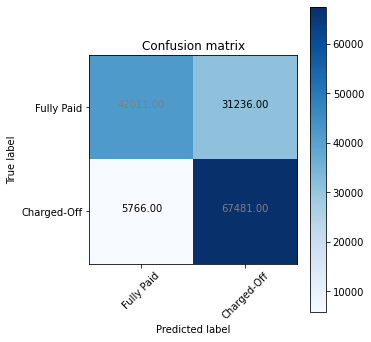

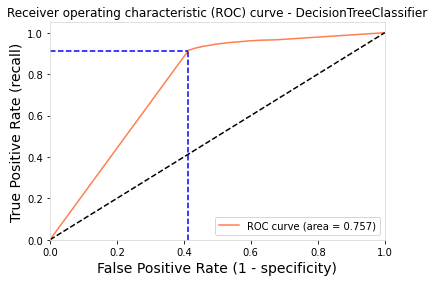

Using a threshold of 1.000 guarantees a sensitivity of 0.911 and a specificity of 0.588, i.e. a false positive rate of 41.23%.
Runtime of the program is 3.240465756257375


In [10]:
# starting time
start = time.time()
from sklearn import tree
dt_model = tree.DecisionTreeClassifier(max_depth = None)
dt_model = fit_predict_evaluate(dt_model, X_train_pca,loan_data_targets_train,
                                X_val_pca, loan_data_targets_validation, df_cv_scores)

end = time.time()
# total time taken
print(f"Runtime of the program is {(end - start)/60}")

### Logistic Regression

In [11]:
lr_model = log_reg = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=5
        ,random_state=777
        ,max_iter=10000
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=10
    )

LogisticRegressionCV:
Accuracy score on training set is 69.96%


C:\Users\WIN8\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


K-fold cross-validation results on validation set:
 average accuracy is 67.45%
 average F1 is 66.89%
 average roc_auc is 73.04%


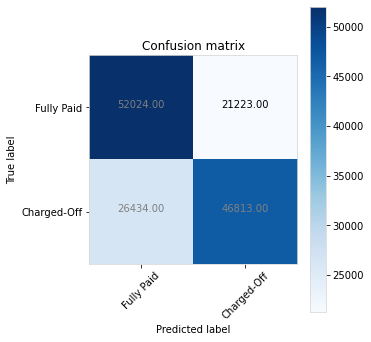

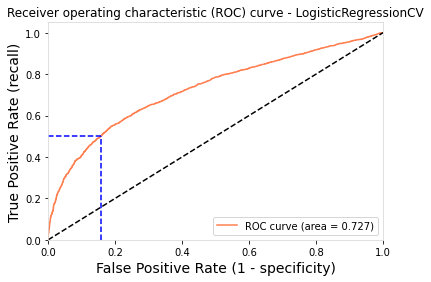

Using a threshold of 0.568 guarantees a sensitivity of 0.500 and a specificity of 0.843, i.e. a false positive rate of 15.65%.
Runtime of the program is 8.092281572024028


In [12]:
start = time.time()
lr_model = fit_predict_evaluate(lr_model, X_train_pca,np.array(loan_data_targets_train.iloc[:,0]),
                                X_val_pca, np.array(loan_data_targets_validation.iloc[:,0]), df_cv_scores)

end = time.time()
# total time taken
print(f"Runtime of the program is {(end - start)/60}")

### Random Forest 

RandomForestClassifier:
Accuracy score on training set is 85.50%


C:\Users\WIN8\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


K-fold cross-validation results on validation set:
 average accuracy is 90.88%
 average F1 is 90.20%
 average roc_auc is 96.91%


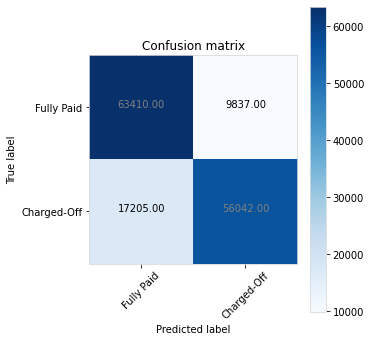

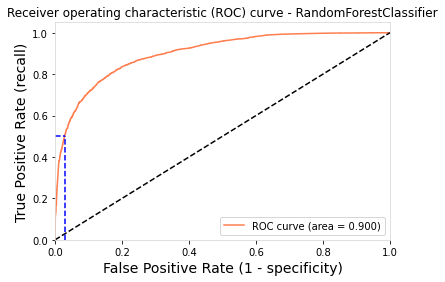

Using a threshold of 0.710 guarantees a sensitivity of 0.500 and a specificity of 0.972, i.e. a false positive rate of 2.81%.
Runtime of the program is 26.875237361590067


In [13]:
start = time.time()
randomf_optim = RandomForestClassifier(n_estimators=200, max_depth=20)
randomf_optim = fit_predict_evaluate(randomf_optim,inputs_train,np.array(loan_data_targets_train.iloc[:,0]),
                                     inputs_validation, np.array(loan_data_targets_validation.iloc[:,0]), df_cv_scores)

end = time.time()
# total time taken
print(f"Runtime of the program is {(end - start)/60}")

### Boosting

AdaBoostClassifier:
Accuracy score on training set is 85.26%


C:\Users\WIN8\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


K-fold cross-validation results on validation set:
 average accuracy is 92.17%
 average F1 is 91.87%
 average roc_auc is 97.52%


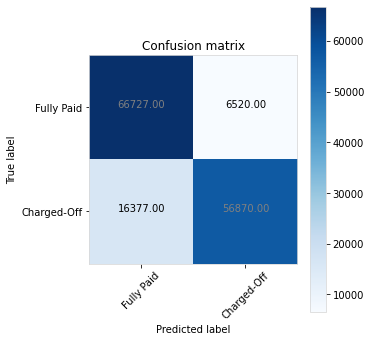

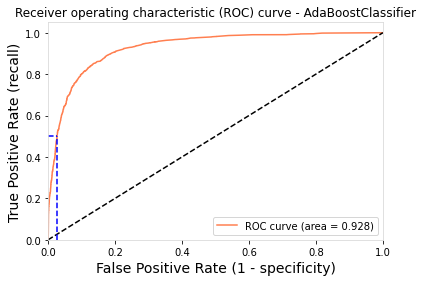

Using a threshold of 0.572 guarantees a sensitivity of 0.500 and a specificity of 0.973, i.e. a false positive rate of 2.67%.
Runtime of the program is 25.875744450092316


In [14]:
start = time.time()
ab_model = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=7), n_estimators=60, learning_rate=0.05)
ab_model = fit_predict_evaluate(ab_model, inputs_train,np.array(loan_data_targets_train.iloc[:,0]),
                                inputs_validation, np.array(loan_data_targets_validation.iloc[:,0]), df_cv_scores)

end = time.time()
# total time taken
print(f"Runtime of the program is {(end - start)/60}")

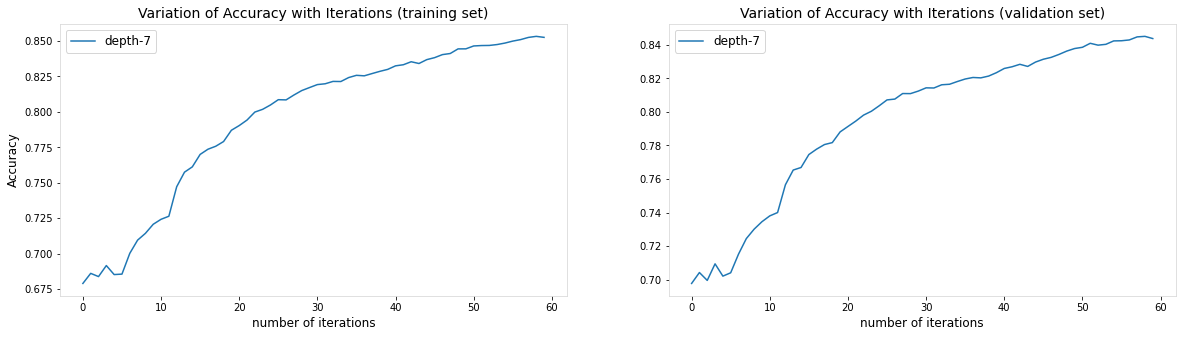

In [15]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
train_scores = list(ab_model.staged_score(inputs_train,loan_data_targets_train))
test_scores = list(ab_model.staged_score(inputs_validation, loan_data_targets_validation))
ax[0].plot(train_scores,label='depth-{}'.format(7))
ax[1].plot(test_scores,label='depth-{}'.format(7))
ax[0].set_xlabel('number of iterations', fontsize=12)
ax[1].set_xlabel('number of iterations', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].set_title("Variation of Accuracy with Iterations (training set)", fontsize=14)
ax[1].set_title("Variation of Accuracy with Iterations (validation set)", fontsize=14)
ax[0].legend(fontsize=12);
ax[1].legend(fontsize=12);    

### Loan Description

Additionally to using quantified predictors, we were curious to see if text would give us some predictive power.

Some studies suggest that words used on loan applications can predict the likelihood of charge-off. In this section we use natural language processing algorithms to extract features from the loan title and description filled in by the borrower when requesting the loan. We then use a Naive Bayes classifier for the classification task.

The function below performs the following preprocessing on the text data:

lower case,
remove punctuation,
remove commonly occuring words using predefined libraries,
remove suffices, like “ing”, “ly”, “s”, etc. by a simple rule-based approach.
correct spelling

In [16]:
def clean_text(text):
    # lower case
    text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))
    # remove punctuation
    text = text.str.replace('[^\w\s]','') 
    # remove stop words    
    stop = stopwords.words('english')
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    # correct spelling
    from textblob import TextBlob
    text = text.apply(lambda x: str(TextBlob(x).correct()))
    # lemmatization     
    text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    return text

In [20]:
# Data preparation
df= pd.read_csv(r'C:\Users\WIN8\Desktop\PGDS 2020\Datasets\Credit Risk Analysis\Lending Club Data Kaggle\loan_data_2007_2014.csv')
df_desc = df[['title', 'desc', 'loan_status']]
df_desc.fillna('N/A', inplace=True)
df_desc['desc'] = df_desc['desc'] + ' - ' + df_desc['title']

# Creating a binary variable for loan status
df_desc['loan_status'] = np.where(df['loan_status'].isin(['Charged Off ', 'Late (31-120 days)',
                                                               'Does not meet the credit policy. Status:Charged Off',
                                                               'Late (31-120 days)', 'Default']), 0, 1)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\WIN8\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel

We use the merged loan title and description as feature, the response variable is the loan status.

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
X_desc = df_desc.title
y_desc = df_desc.loan_status
X_train_desc, X_test_desc, y_train_desc, y_test_desc = train_test_split(X_desc, y_desc, test_size=0.2, stratify=y_desc)
X_train_desc, X_val_desc, y_train_desc, y_val_desc = train_test_split(X_train_desc, y_train_desc, test_size=0.2, stratify=y_train_desc)

X_train_desc, y_train_desc = resample(X_train_desc, y_train_desc, n_samples=round(loan_data_targets_train.shape[0]))
X_val_desc, y_val_desc = resample(X_val_desc, y_val_desc, n_samples=round(loan_data_targets_validation.shape[0]))
X_test_desc, y_test_desc = resample(X_test_desc, y_test_desc, n_samples=round(loan_data_targets_test.shape[0]))



We extract TF-IDF features. TF-IDF is the multiplication of the TF and IDF. The IDF of each word is the log of the ratio of the total number of rows to the number of rows in which that word is present. TF or term frequency is the ratio of the count of a word present in a sentence, to the length of the sentence.

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
word_vectorizer = TfidfVectorizer(
    stop_words='english',
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{2,}', 
    ngram_range=(1, 1),
    max_features=30000)

word_vectorizer.fit(X_train_desc)
X_train_desc_features = word_vectorizer.transform(X_train_desc)

#transform the val and test features to sparse matrix
X_val_desc_features = word_vectorizer.transform(X_val_desc)
X_test_desc_features = word_vectorizer.transform(X_test_desc)

print("Our training data has {} loans, each with {} text features.".format(X_train_desc_features.shape[0], 
                                                                           X_train_desc_features.shape[1]))

Our training data has 585974 loans, each with 10412 text features.


### Naive Bayes

In [50]:
from sklearn.naive_bayes import MultinomialNB
# Applying Naive Bayes on the descriptions.
nb_model = MultinomialNB()

nb_model = fit_predict_evaluate(nb_model, X_train_desc_features, y_train_desc, X_val_desc_features,
                                y_val_desc, df_cv_scores)

MultinomialNB:
Accuracy score on training set is 98.16%


C:\Users\WIN8\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


K-fold cross-validation results on validation set:
 average accuracy is 98.18%
 average F1 is 99.08%
 average roc_auc is 50.61%


ValueError: Length of values (74606) does not match length of index (146494)

Our Naive Bayes did not find enough information that would clearly distinguish the two classes of loans.

However the ROC-AUC score was above 50%, this was a suprise for us. The F1 score and classification accuracy was more than average. We see this as a sign that the text data contains a sort of signal that if properly preprocessed, would contribute in a loan classification problem.

## Model Selection

### Scoring Benchmark

All models investigated in this project are compared in the table below. The performance was evaluated in a out-of-sample manner on the validation set using 3-folds cross-validation.

For each model, we can compare different metrics (accuracy, F1, ROC_AUC). We are also able to compare models using the metric ROC_AUC, which reflect their performance when we set probability cutoff at 50%.

In [56]:
df_cv_scores_report = df_cv_scores.copy()
df_cv_scores_report.drop('model', inplace=True, errors='ignore')
df_cv_scores_report.sort_values(by=['roc_auc'], ascending=False, inplace=True)
df_cv_scores_report.reset_index(inplace=True)
df_cv_scores_report.rename(columns={'index':'model'}, inplace=True)
df_cv_scores_report

,model,accuracy,f1,roc_auc
0,AdaBoostClassifier,0.921731,0.918750,0.975221
1,RandomForestClassifier,0.908822,0.902034,0.969094
2,DecisionTreeClassifier,0.958428,0.957097,0.961315
3,LogisticRegressionCV,0.674499,0.668891,0.730360
4,MultinomialNB,0.981784,0.990808,0.506057


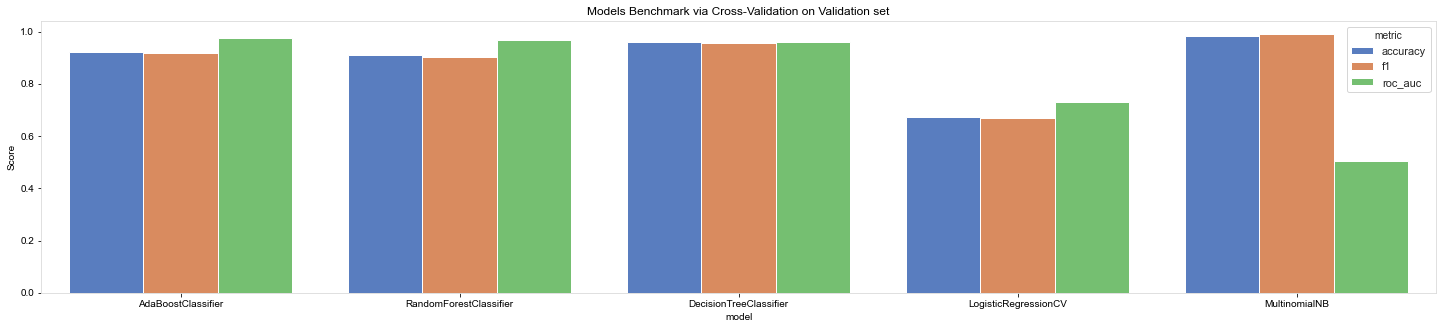

In [58]:
import seaborn as sns
df_cv_scores_melt = pd.melt(df_cv_scores_report, id_vars=['model'], var_name='metric', value_name='score')
fig, ax = plt.subplots(1,1,figsize=(25,5))
sns.set(style="whitegrid")
sns.barplot(x="model", y="score", hue="metric", data=df_cv_scores_melt, palette="muted", ax=ax)
ax.set_title("Models Benchmark via Cross-Validation on Validation set")
ax.set_ylabel("Score");

We found that ADA Boost gives us the best results. But we need the coefficients of the model for interpretability.

### Building a Logistic Regression Model with P-values

We will select only those independent variables for our final model that help us to predict the default. We will now compute the p-values to check the statistical significance of the coefficents. The sklearn methods of calculating p-values are univariate, i.e. they take into account the impact of each feature on the outcome. In a regression model the impact of all the features is collective, rather than independent. Thus we will calculate the multivariate p-values. We can achieve this by altering the fit method of the sklearn library.

In [173]:
from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self, *args, **kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)
        
    def fit(self, X, y):
        self.model.fit(X,y)
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X)
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values
        

In [174]:
reg2 = LogisticRegression_with_p_values()
reg2.fit(inputs_train, np.array(loan_data_targets_train.iloc[:,0]))
# Formatting the results
feature_name = inputs_train.columns.values

C:\Users\WIN8\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [239]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
# Adding the coefficients to the first row
# Shifting rows by 1 place down
summary_table.index = summary_table.index + 1
# Filling the first row with the intercept
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
# Sorting by index
summary_table = summary_table.sort_index()
summary_table.head()

,Feature name,Coefficients
0,Intercept,-7.994189
1,home_ownership:MORTGAGE,0.136318
2,addr_state:AK_DC_KS_WY_ID_ME,3.537274
3,addr_state:SD_OK_MS_MT_NE_IA_ND,2.458554
4,addr_state:TN_HI_NV,2.058154


In [240]:
#  Adding the p-values to the summary_table
p_values = reg.p_values

Our p_values dont have a p-Value for the Intercept. Lets add a nan value for the intercept under the p-value column.

In [241]:
p_values = np.append(np.nan, np.array(p_values))

In [242]:
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-7.994189,NaN
1,home_ownership:MORTGAGE,0.136318,4.885153e-53
2,addr_state:AK_DC_KS_WY_ID_ME,3.537274,0.000000e+00
3,addr_state:SD_OK_MS_MT_NE_IA_ND,2.458554,0.000000e+00
4,addr_state:TN_HI_NV,2.058154,0.000000e+00
...,...,...,...
64,dti:>30,1.352019,0.000000e+00
65,mths_since_last_record:0-15,-0.789703,1.400191e-71
66,mths_since_last_record:15-38,0.145100,4.964428e-04
67,mths_since_last_record:38-72,0.099639,2.424652e-03


#### Predicting on test

In [243]:
# Selecting the variables
inputs_test_with_ref_cat = loan_data_inputs_test.loc[:,['home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:MORTGAGE',
'addr_state:AK_DC_KS_WY_ID_ME',
'addr_state:SD_OK_MS_MT_NE_IA_ND',
'addr_state:TN_HI_NV',
'addr_state:AZ_RI_NY',
'addr_state:VA_LA',
'addr_state:MD_AL_IN_MO',
'addr_state:MA_AR',
'addr_state:MI_DE_WI',
'addr_state:NC_NM',
'addr_state:CO_MN_NH_KY_VT',
'addr_state:SC_WV_UT',
'purpose:house_moving',
'purpose:other_medical',
'purpose:vacation_major_purchase',
'purpose:wedding_renewable_energy',
'sub_grade:G5_G3_G4',
'sub_grade:G1_G2_F3_F5',
'sub_grade:E2_E4_F4_E5_F1_F2',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2',
'emp_length:3',
'emp_length:4',
'emp_length:5',
'emp_length:6',
'emp_length:7',
'emp_length:8',
'emp_length:9',
'emp_length:10',
'months_issue_d_date:<49',
'months_issue_d_date:49-54',
'months_issue_d_date:55-61',
'months_issue_d_date:62-77',
'months_issue_d_date:>77',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'months_since_earliest_cr_line:<153',
'months_since_earliest_cr_line:154-258',
'months_since_earliest_cr_line:<258-387',
'months_since_earliest_cr_line:<387',
'delinq_2yrs:<5',
'delinq_2yrs:5-10',
'delinq_2yrs:>10',
'inq_last_6mths:<4',
'inq_last_6mths:4-6',
'inq_last_6mths:>6',
'acc_now_delinq:<1',
'acc_now_delinq:>1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-7',
'mths_since_last_delinq:7-18',
'mths_since_last_delinq:18-36',
'mths_since_last_delinq:36-54',
'mths_since_last_delinq:54-82',
'mths_since_last_delinq:>=82',
'dti:<12',
'dti:12-18',
'dti:18-22',
'dti:22-30',
'dti:>30',
'mths_since_last_record:Missing',
'mths_since_last_record:0-15',
'mths_since_last_record:15-38',
'mths_since_last_record:38-72',
'mths_since_last_record:>=72']]


# Removing the 1 extra dummy variable from the reference categories.
ref_categories = ['home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:SC_WV_UT',
'purpose:wedding_renewable_energy',
'sub_grade:G5_G3_G4',
'term:36',
'emp_length:0',
'months_issue_d_date:<49',
'int_rate:<9.548',
'months_since_earliest_cr_line:<153',
'delinq_2yrs:<5',
'inq_last_6mths:<4',
'acc_now_delinq:<1',
'annual_inc:<20K',
'mths_since_last_delinq:Missing',
'dti:<12',
'mths_since_last_record:Missing']

inputs_test = inputs_test_with_ref_cat.drop(ref_categories, axis = 1)
inputs_test.head()

,home_ownership:MORTGAGE,addr_state:AK_DC_KS_WY_ID_ME,addr_state:SD_OK_MS_MT_NE_IA_ND,addr_state:TN_HI_NV,addr_state:AZ_RI_NY,addr_state:VA_LA,addr_state:MD_AL_IN_MO,addr_state:MA_AR,addr_state:MI_DE_WI,addr_state:NC_NM,...,mths_since_last_delinq:54-82,mths_since_last_delinq:>=82,dti:12-18,dti:18-22,dti:22-30,dti:>30,mths_since_last_record:0-15,mths_since_last_record:15-38,mths_since_last_record:38-72,mths_since_last_record:>=72
0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [244]:
y_hat_test = reg2.model.predict(inputs_test)

In [245]:
y_hat_test_proba = reg2.model.predict_proba(inputs_test)

In [246]:
y_hat_test

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [247]:
# Computing the predicted probabilities
y_hat_test_proba = reg2.model.predict_proba(inputs_test)
y_hat_test_proba

array([[0.  , 1.  ],
       [0.39, 0.61],
       [0.  , 1.  ],
       ...,
       [0.98, 0.02],
       [0.99, 0.01],
       [0.91, 0.09]])

The above returns arrays having 2 elements for each borrower. The first one explains the probability of being a bad borrower (PD) and the second one explains the probability of being a good borrower (1 - PD).

In [248]:
y_hat_test_proba.shape

(183116, 2)

In [249]:
y_hat_test_proba = y_hat_test_proba[:][:,1]

In [250]:
y_hat_test_proba

array([1.  , 0.61, 1.  , ..., 0.02, 0.01, 0.09])

In [251]:
loan_data_targets_test_temp = loan_data_targets_test
loan_data_targets_test_temp.reset_index(drop = True, inplace = True)

In [252]:
df_actual_predicted_probs = pd.concat([loan_data_targets_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)

In [253]:
df_actual_predicted_probs.shape

(183116, 2)

In [254]:
# Renaming the columns
df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']
# Resetting the index as the index of loan_data_inputs_test
df_actual_predicted_probs.index = loan_data_inputs_test.index

In [255]:
df_actual_predicted_probs.head()

,loan_data_targets_test,y_hat_test_proba
0,1,0.997203
1,1,0.613478
2,1,0.997261
3,1,0.832419
4,1,0.983342


### Accuracy and AUC 

In [256]:
# Setting the default threshold
tr = 0.90
# Sorting by threshold
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr,1,0)

In [257]:
df_actual_predicted_probs.head()

,loan_data_targets_test,y_hat_test_proba,y_hat_test
0,1,0.997203,1
1,1,0.613478,0
2,1,0.997261,1
3,1,0.832419,0
4,1,0.983342,1


In [258]:
# Creating a Confusion Matrix
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
           rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,90432,1126
1,44602,46956


In [259]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
           rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.493851,0.006149
1,0.243572,0.256428


In [260]:
# Calculating Accuracy
(pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
           rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0,0] + (pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
           rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1,1]

0.7502785119814762

We get an accuracy of 75.02%.

In [261]:
from sklearn.metrics import roc_curve, roc_auc_score

In [262]:
roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])

(array([0., 0., 0., ..., 1., 1., 1.]),
 array([0.00e+00, 1.09e-05, 5.59e-03, ..., 1.00e+00, 1.00e+00, 1.00e+00]),
 array([2.00e+00, 1.00e+00, 1.00e+00, ..., 1.40e-04, 1.22e-04, 7.60e-05]))

In [263]:
fpr,tpr,thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'],
                              df_actual_predicted_probs['y_hat_test_proba'])

In [264]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'ROC curve')

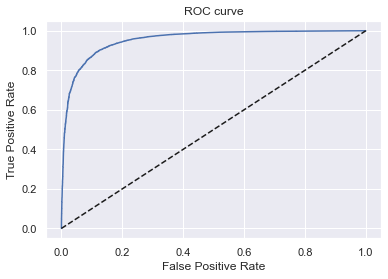

In [265]:
# ROC 
plt.plot(fpr,tpr)
# Benchmark (predicting by chance)
plt.plot(fpr,fpr,linestyle = '--', color = 'k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

In [266]:
# Calculating the AUROC
AUROC = roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
AUROC

0.9542114545855291

We get a fair AUROC score of 95.42%

### Gini Coefficient & Kolmogorov-Smirnov

In [267]:
# Soritng by predicted probabilites in ascending order
df_actual_predicted_probs = df_actual_predicted_probs.sort_values('y_hat_test_proba')
df_actual_predicted_probs.head()

,loan_data_targets_test,y_hat_test_proba,y_hat_test
111772,0,0.000076,0
182578,0,0.000076,0
103315,0,0.000076,0
161021,0,0.000076,0
161123,0,0.000076,0


In [268]:
# Reindexing the data
df_actual_predicted_probs = df_actual_predicted_probs.reset_index()
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test
0,111772,0,0.000076,0
1,182578,0,0.000076,0
2,103315,0,0.000076,0
3,161021,0,0.000076,0
4,161123,0,0.000076,0


In [269]:
# Cumulative % of total population, good and bad borrowers
df_actual_predicted_probs['Cumulative N Population'] = df_actual_predicted_probs.index + 1
df_actual_predicted_probs['Cumulative N Good'] = df_actual_predicted_probs['loan_data_targets_test'].cumsum()
df_actual_predicted_probs['Cumulative N Bad'] = df_actual_predicted_probs['Cumulative N Population'] - df_actual_predicted_probs['loan_data_targets_test'].cumsum()

In [270]:
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad
0,111772,0,0.000076,0,1,0,1
1,182578,0,0.000076,0,2,0,2
2,103315,0,0.000076,0,3,0,3
3,161021,0,0.000076,0,4,0,4
4,161123,0,0.000076,0,5,0,5


In [271]:
# Calculating Percentages
df_actual_predicted_probs['Cumulative Perc Population'] = df_actual_predicted_probs['Cumulative N Population'] / df_actual_predicted_probs.shape[0]
df_actual_predicted_probs['Cumulative Perc Good'] = df_actual_predicted_probs['Cumulative N Good'] / df_actual_predicted_probs['loan_data_targets_test'].sum()
df_actual_predicted_probs['Cumulative Perc Bad'] = df_actual_predicted_probs['Cumulative N Bad'] / (df_actual_predicted_probs.shape[0] - df_actual_predicted_probs['loan_data_targets_test'].sum())


Text(0.5, 1.0, 'Gini')

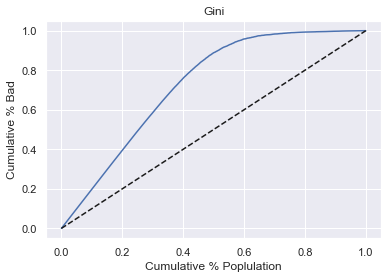

In [272]:
# Plotting Gini
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Bad'])
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Population'],
         linestyle = '--', color = 'k')
plt.xlabel('Cumulative % Poplulation')
plt.ylabel('Cumulative % Bad')
plt.title('Gini')

In [273]:
Gini = AUROC *2 -1
Gini

0.9084229091710583

The Gini coefficient for our model is 90.84%

Text(0.5, 1.0, 'Kolmogorov-Smirnov')

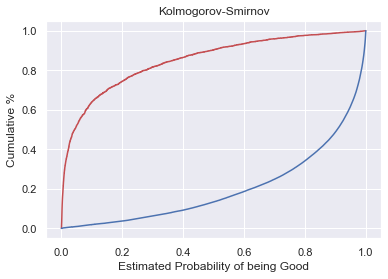

In [274]:
# Plotting the Kolmogorov-Smirnov plot
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Bad'], color = 'r')
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Good'], color = 'b')
plt.xlabel('Estimated Probability of being Good')
plt.ylabel('Cumulative %')
plt.title('Kolmogorov-Smirnov')

In [275]:
KS = max(df_actual_predicted_probs['Cumulative Perc Bad'] - df_actual_predicted_probs['Cumulative Perc Good'])
KS

0.7771248825880862

The two cumulative distribution functions are sufficiently far away from each other and the model has satisfactory predictive power.